<a href="https://colab.research.google.com/github/yk-Jeong/Kaggle-Studies/blob/main/3rd_weeks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.0 Data prep

In [22]:
#https://dacon.io/competitions/official/235590/codeshare/949

In [23]:
from IPython.display import HTML
import pandas as pd
import numpy as np 

In [24]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation as animation
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [25]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [26]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import warnings
warnings.filterwarnings('ignore')

In [27]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
patient = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/study/data/coronavirusdataset_20200430/PatientInfo.csv')
patient.head(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released


In [29]:
print(patient.shape, len(patient.patient_id.unique()))

(3388, 18) 3388


In [30]:
data = patient.copy()

1.1 Infection route cases

In [31]:
print('the number of unique values in infection_case:', len(data['infection_case'].unique()))
data['infection_case'].unique()

the number of unique values in infection_case: 24


array(['overseas inflow', 'contact with patient', 'Seongdong-gu APT',
       'etc', "Eunpyeong St. Mary's Hospital", 'Shincheonji Church',
       'Dongan Church', 'Guro-gu Call Center', 'Onchun Church',
       'Cheongdo Daenam Hospital', 'Suyeong-gu Kindergarten', nan,
       'Ministry of Oceans and Fisheries', 'gym facility in Cheonan',
       'gym facility in Sejong', 'River of Grace Community Church',
       'Gyeongsan Seorin Nursing Home',
       'Gyeongsan Cham Joeun Community Center',
       'Gyeongsan Jeil Silver Town', 'Bonghwa Pureun Nursing Home',
       'Pilgrimage to Israel', 'Milal Shelter', 'Geochang Church',
       'Changnyeong Coin Karaoke'], dtype=object)

In [32]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id' : 'count'}, inplace=True)
g = g.sort_values('count', ascending=False)
g

,infection_case,count
18,contact with patient,968
22,overseas inflow,604
19,etc,572
6,Guro-gu Call Center,112
16,Shincheonji Church,107
12,Onchun Church,33
0,Bonghwa Pureun Nursing Home,31
20,gym facility in Cheonan,30
11,Ministry of Oceans and Fisheries,28
2,Cheongdo Daenam Hospital,21


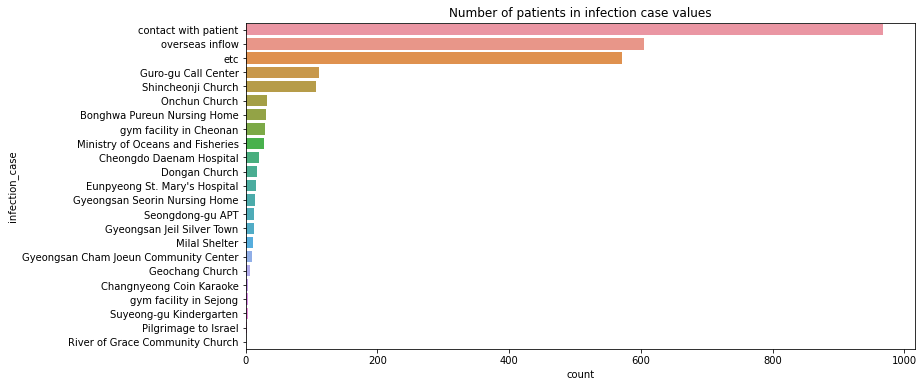

In [33]:
plt.figure(figsize=(12, 6))
plt.title('Number of patients in infection case values')
sns.barplot(y = 'infection_case', x = 'count', data = g)
display()

In [34]:
g = data.groupby(['infection_case'])['patient_id'].count()
g = pd.DataFrame(g)

In [35]:
g

,patient_id
infection_case,
Bonghwa Pureun Nursing Home,31
Changnyeong Coin Karaoke,4
Cheongdo Daenam Hospital,21
Dongan Church,17
Eunpyeong St. Mary's Hospital,16
Geochang Church,6
Guro-gu Call Center,112
Gyeongsan Cham Joeun Community Center,10
Gyeongsan Jeil Silver Town,12


In [36]:
infection_case_less_than_5 = g[g['patient_id']<5].index.tolist()
g[g.index.isin(infection_case_less_than_5)]

,patient_id
infection_case,
Changnyeong Coin Karaoke,4
Pilgrimage to Israel,2
River of Grace Community Church,1
Suyeong-gu Kindergarten,3
gym facility in Sejong,4


In [37]:
print('original data shape:', data.shape) 
data = data[~ (data['infection_case'].isin(infection_case_less_than_5))]
print('data shape after slicing: ', data.shape)

original data shape: (3388, 18)
data shape after slicing:  (3374, 18)


In [38]:
#결측치 확인
data[data['infection_case'].isna()].shape 

(768, 18)

In [39]:
#카테고리 재지정 함수 

def categorisation(x):
  if x == 'overseas inflow':
    y = 'overseas'
  elif x == 'contact with patient':
    y = 'individual'
  elif (x == 'etc') | (pd.isna(x)):
    y = 'unknown'
  else:
    y = 'group'
  return y 

In [40]:
#함수 적용 후 결과 확인
data['infection'] = data['infection_case'].apply(lambda x: categorisation(x))
print(data.shape)
data.head()

(3374, 19)


,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual


In [41]:
g = data.groupby(['infection'])['patient_id'].count()
g = g.reset_index()
g.rename(columns = {'patient_id': 'count'}, inplace = True)

In [42]:
g = g.sort_values('count', ascending = False)

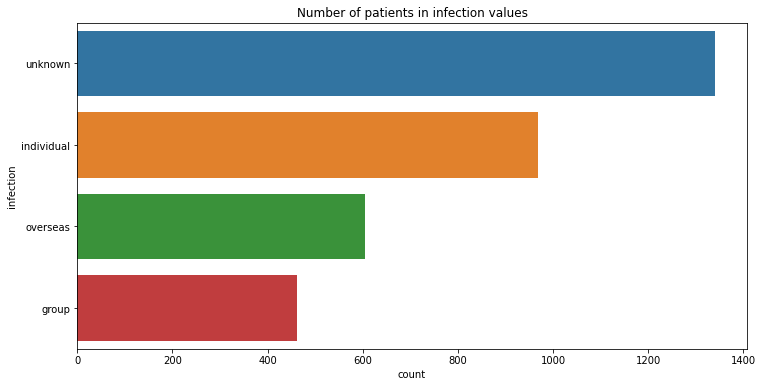

In [43]:
plt.figure(figsize = (12, 6))
sns.barplot(y = 'infection', x = 'count', data = g)
plt.title('Number of patients in infection values')
display()

1.2 Mobility level

In [45]:
route = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/study/data/coronavirusdataset_20200430/PatientRoute.csv")
route.head()

,patient_id,global_num,date,province,city,type,latitude,longitude
0,1000000001,2.00,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.62,126.72
1,1000000001,2.00,2020-01-24,Seoul,Jung-gu,hospital,37.57,127.01
2,1000000002,5.00,2020-01-25,Seoul,Seongbuk-gu,etc,37.59,127.02
3,1000000002,5.00,2020-01-26,Seoul,Seongbuk-gu,store,37.59,127.02
4,1000000002,5.00,2020-01-26,Seoul,Seongdong-gu,public_transportation,37.56,127.03


In [46]:
print('The number of unique values in type:', len(route['type'].unique()))
route['type'].unique()

The number of unique values in type: 24


array(['airport', 'hospital', 'etc', 'store', 'public_transportation',
       'restaurant', 'church', 'beauty_salon', 'pharmacy', 'pc_cafe',
       'bank', 'cafe', 'bakery', 'bar', 'gym', 'school',
       'real_estate_agency', 'karaoke', 'post_office', 'gas_station',
       'lodging', 'academy', 'university', 'administrative_area_level_1'],
      dtype=object)

In [47]:
route[route['type'].isna()].shape

(0, 8)

In [49]:
leisure = ['library', 'theater', 'cafe', 'bakery', 'beauty_salon', 'pc_cafe', 'billiards','restaurant', 'bar', 'karaoke']
travel = ['airport', 'lodging']
essential_edu = ['primary_school', 'school', 'university']
non_essential_edu = ['academy']
exercise = ['gym', 'mountain', 'park']
essential_admin = ['administrative_area_level_1', 'governmnet_office', 'post_office']
non_essential_admin = ['police_office', 'bank', 'real_estate_agency']
necessity = ['store', 'public_transportation', 'gas_station']
medical = ['hospital', 'pharmacy']
church = ['church']
etc = ['etc']

In [50]:
essential = essential_edu + essential_admin + necessity + medical

In [51]:
def type_group_essen(x):
  group = None
  if x in essential:
    group = 'essential'
  else:
    group = 'non-essential'
  return group

In [53]:
route['route_group_essential'] = route['type'].apply(lambda x: type_group_essen(x))
route = route[['patient_id', 'type', 'route_group_essential']]
route.head()

,patient_id,type,route_group_essential
0,1000000001,airport,non-essential
1,1000000001,hospital,essential
2,1000000002,etc,non-essential
3,1000000002,store,essential
4,1000000002,public_transportation,essential


In [54]:
route['route_value'] = 1
g = pd.DataFrame(route.groupby(['patient_id', 'route_group_essential'])['route_value'].count().unstack())
g

route_group_essential,essential,non-essential
patient_id,,
1000000001,1.00,1.00
1000000002,9.00,4.00
1000000003,nan,2.00
1000000004,1.00,nan
1000000005,1.00,nan
...,...,...
6100000086,2.00,2.00
6100000087,6.00,2.00
6100000088,5.00,19.00


In [56]:
g.fillna(0,inplace=True)
g.reset_index(inplace=True)
g = g[['patient_id', 'essential', 'non-essential']]
g.head()

route_group_essential,patient_id,essential,non-essential
0,1000000001,1.00,1.00
1,1000000002,9.00,4.00
2,1000000003,0.00,2.00
3,1000000004,1.00,0.00
4,1000000005,1.00,0.00


In [57]:
data = data.merge(g, left_on = 'patient_id', right_on = 'patient_id', how = 'left')
data.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
0,1000000001,2.00,male,1964.00,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.00,nan,75.00,2020-01-22,2020-01-23,2020-02-05,NaN,released,overseas,1.00,1.00
1,1000000002,5.00,male,1987.00,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.00,nan,31.00,NaN,2020-01-30,2020-03-02,NaN,released,overseas,9.00,4.00
2,1000000003,6.00,male,1964.00,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.00,2002000001.00,17.00,NaN,2020-01-30,2020-02-19,NaN,released,individual,0.00,2.00
3,1000000004,7.00,male,1991.00,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.00,nan,9.00,2020-01-26,2020-01-30,2020-02-15,NaN,released,overseas,1.00,0.00
4,1000000005,9.00,female,1992.00,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.00,1000000002.00,2.00,NaN,2020-01-31,2020-02-24,NaN,released,individual,1.00,0.00


In [60]:
print(data.shape)
data[(data['essential'].isna()) | (data['non-essential'].isna())].shape

(3374, 21)


(2170, 21)

1.3. Number of contacts

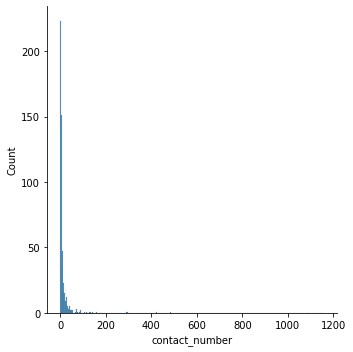

In [61]:
sns.displot(data['contact_number'])
display()

In [62]:
data['contact_number'].describe()

count    635.00
mean      18.22
std       74.18
min        0.00
25%        2.00
50%        4.00
75%       13.00
max     1160.00
Name: contact_number, dtype: float64

In [63]:
#contact_number가 max인 data 확인
data[data['contact_number'] == 1160] 

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,infection,essential,non-essential
764,1200000031,31.00,female,1959.00,60s,Korea,Daegu,NaN,NaN,Shincheonji Church,nan,nan,1160.00,NaN,2020-02-18,NaN,NaN,isolated,group,11.00,5.00


'극단적 값을 갖는 확진자들을 outlier로 봐야하는지에 조심스러운 해석이 필요합니다. 특히나 이번 분석의 주요 특성 중 하나인 '감염 경로'에 '집단감염'이 있고, 극단적인 접촉 정도를 가진 확진자들은 집단감염의 사례였을 가능성이 있습니다. 또는 극단적 값을 가진 사례가 '개인감염'이었다면, 이는 집단감염과 구분지을 수 있는 척도가 됩니다. 

*따라서 contact_number의 값을 모두 활용하기로 합니다*.

다만 그 값을 갖지 않는 사람들은 위의 '유동성'과 마찬가지로 "접촉이 없었다"고 확신할 근거가 없습니다. 따라서 접촉 횟수의 값이 없는 사람들은 모두 제거합니다'

1.4 Diagnosis time

In [64]:
print('data shape:', data.shape)
print('missing values in symptom_onset_date:', data[data['symptom_onset_date'].isna()].shape)
print('missing values in confirmed_date:', data[data['confirmed_date'].isna()].shape)

data shape: (3374, 21)
missing values in symptom_onset_date: (2900, 21)
missing values in confirmed_date: (3, 21)
